## Fashion MNIST Dataset을 사용하여 분류 실습
CNN (Convolutional Neural Network)를 사용하여 Fashion MNIST 데이터셋을 분류해보자.

In [1]:
### 라이브러리 임포트
import os
import sys

import logging		# 코드의 출력 결과를 기록하기 위한 라이브러리
import argparse		# hyper parameter를 조절하기 위한 라이브러리
import random		

import torch					                # 신경망 학습을 위한 라이브러리
import torch.nn as nn				            # 신경망 학습을 위한 라이브러리						
import torch.optim as optim			            # Optimizer를 사용하기 위한 라이브러리
from torchvision import datasets, transforms	# 데이터셋을 다운로드 및 변환하기 위한 라이브러리
import numpy as np				                # 리스트 조작을 위한 라이브러리

from matplotlib import pyplot as plt	# 시각화를 위한 라이브러리

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))
# utils 함수를 생성하여 함수 초기화, logging 등을 도와주는 파일입니다.
from utils import AverageMeter, config_logging

In [2]:
# argument 세팅
parser = argparse.ArgumentParser(description='Fashion MNIST Classfication')

parser.add_argument('--batch_size', default=64, type=int,
                    help='Dataset batch_size')
parser.add_argument('--num_epochs', default=50, type=int,
                    help='num epochs')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate')

parser.add_argument('--comment', type=str, default='_CNN')


args = parser.parse_args('')	# 단순 python 파일로 실행할 때는 () 안에 ''를 넣지 않습니다.
comment = args.comment

config_logging(comment)
logging.info('args: {}'.format(args))

2022-03-05 17:45:50,429 [INFO ] args: Namespace(batch_size=64, comment='_CNN', learning_rate=0.001, num_epochs=50)


Fashion_MNIST


In [3]:
### GPU 설정
device = torch.device("cuda:0")
logging.info("device: {}".format(device))

2022-03-05 17:45:50,481 [INFO ] device: cuda:0


In [4]:
### transform 설정
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

### Fashion MNIST Dataset
* 60,000개의 train data, 10,000개의 test data로 이루어짐
* 0 - T-Shirts </br>
1 - Trouser </br>
2- Pullover </br>
3 - Dress </br>
4 - Coat </br>
5 - Sandal </br>
6 - Shirt </br>
7 - Sneanker </br>
8 - Bag </br>
9 - Ankle boot 와 같은 클래스를 갖는 데이터셋
* 한장의 이미지는 28x28의 크기를 갖음


In [5]:
### Dataset 다운로드
root = '../MNIST_Fashion'
trainset = datasets.FashionMNIST(root=root, 
                                 download=True, 
                                 train=True, 
                                 transform=transform)
testset = datasets.FashionMNIST(root=root,
                                 download=True,  
                                 train=False, 
                                 transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size=args.batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, 
                                          batch_size=args.batch_size, 
                                          shuffle=False)

logging.info("train data length: {}, test data length: {}".format(len(trainset), len(testset)))

C:\Users\user\anaconda3\envs\transformer\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
2022-03-05 17:45:50,617 [INFO ] train data length: 60000, test data length: 10000


In [6]:
def imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1,2,0)))
    plt.axis('off')
    plt.show()

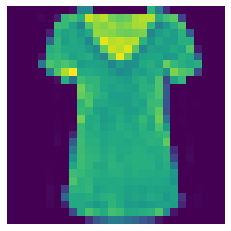

Category is a T-Shirt


In [7]:
label_tags = {
    0: 'T-Shirt', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}

idx = random.randint(0,64)

sample_data = iter(train_loader)
images, labels = next(sample_data)
imshow(images[idx])
print('Category is a {}'.format(label_tags[labels[idx].item()]))

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
                                                            # batchx1x28x28
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16,       # batchx16x28x28
                      kernel_size=3, stride=1, padding=1),   
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2,2),                             
            
            nn.Conv2d(in_channels=16, out_channels=32,      # batchx32x14x14 
                      kernel_size=3, stride=1, padding=1),   
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),

            nn.Conv2d(in_channels=32, out_channels=64,      # batchx64x7x7    
                      kernel_size=3, stride=1, padding=1),      
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(64*7*7, 784),
            nn.ReLU(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        x = self.layer(x)
        
        return x

In [9]:
model = CNN()
epochs = args.num_epochs

total_loss = []
for epoch in range(1, epochs+1):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

    logging.info('Train Phase, Epochs: {}'.format(epoch))
    model.train()
    train_loss = AverageMeter()

    for batch_num, data in enumerate(train_loader):
        images, labels = data

        images = images.view(-1,1,28,28).to(device)
        labels = labels.to(device)
     
        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.update(loss.item(), images.shape[0])
        
        if batch_num % 100 == 0:
            logging.info(
                "[{}/{}] # {}/{} loss: {:.4f}".format(epoch, epochs, 
                                                     batch_num, len(train_loader), train_loss.val)
            )
    total_loss.append(train_loss.avg)

2022-03-05 17:45:52,823 [INFO ] Train Phase, Epochs: 1
C:\Users\user\anaconda3\envs\transformer\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
2022-03-05 17:45:55,606 [INFO ] [1/50] # 0/938 loss: 2.3245
2022-03-05 17:45:57,218 [INFO ] [1/50] # 100/938 loss: 0.3455
2022-03-05 17:45:58,806 [INFO ] [1/50] # 200/938 loss: 0.3383
2022-03-05 17:46:00,402 [INFO ] [1/50] # 300/938 loss: 0.3391
2022-03-05 17:46:01,980 [INFO ] [1/50] # 400/938 loss: 0.1976
2022-03-05 17:46:03,488 [INFO ] [1/50] # 500/938 loss: 0.5955
2022-03-05 17:46:05,001 [INFO ] [1/50] # 600/938 loss: 0.3639
2022-03-05 17:46:06,558 [INFO ] [1/50] # 700/938 loss: 0.3743
2022-03-05 17:46:08,051 [INFO ] [

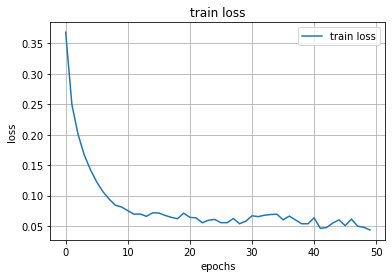

In [10]:
plt.plot(total_loss)
plt.title('train loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.legend(['train loss'])
plt.show()

In [11]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

count = 0
ans = 0

class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

logging.info('Test Phase...')
with torch.no_grad():
    model.eval()

    for batch_num, data in enumerate(test_loader):
        images, labels = data

        images = images.view(-1,1,28,28).to(device)
        labels = labels.to(device)

        output = model(images)
        predict = torch.max(output, 1)[1].to(device)
        is_correct = (predict == labels).squeeze()

        for i in range(len(is_correct)):
            label = labels[i]
            
            ans += is_correct[i].item()   
            count += 1
            
            class_correct[label] += is_correct[i].item()
            total_correct[label] += 1

logging.info('Total Accuracy: {:.4f}%'.format((ans/count)*100))

for i in range(10):
    logging.info("Accuracy of class {}: {:.4f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

2022-03-05 17:56:27,796 [INFO ] Test Phase...
2022-03-05 17:56:30,704 [INFO ] Total Accuracy: 90.6900%
2022-03-05 17:56:30,705 [INFO ] Accuracy of class T-shirt/Top: 88.5000%
2022-03-05 17:56:30,705 [INFO ] Accuracy of class Trouser: 98.3000%
2022-03-05 17:56:30,706 [INFO ] Accuracy of class Pullover: 87.1000%
2022-03-05 17:56:30,706 [INFO ] Accuracy of class Dress: 90.8000%
2022-03-05 17:56:30,706 [INFO ] Accuracy of class Coat: 91.0000%
2022-03-05 17:56:30,707 [INFO ] Accuracy of class Sandal: 98.0000%
2022-03-05 17:56:30,707 [INFO ] Accuracy of class Shirt: 62.7000%
2022-03-05 17:56:30,707 [INFO ] Accuracy of class Sneaker: 97.5000%
2022-03-05 17:56:30,708 [INFO ] Accuracy of class Bag: 98.4000%
2022-03-05 17:56:30,708 [INFO ] Accuracy of class Ankle Boot: 94.6000%


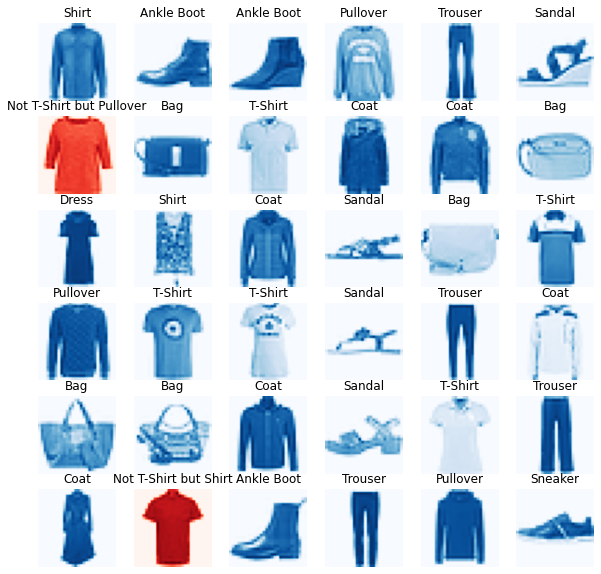

In [12]:
label_tags = {
    0: 'T-Shirt', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}
columns = 6
rows = 6
fig = plt.figure(figsize=(10,10))
 
model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(testset))
    input_img = testset[data_idx][0].unsqueeze(dim=0).to(device) 
 
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = label_tags[argmax.item()]
    label = label_tags[testset[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred)
        cmap = 'Blues'
    else:
        plt.title('Not ' + pred + ' but ' +  label)
        cmap = 'Reds'
    plot_img = testset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')
    
plt.show() 